In [57]:
# !pip3 install openai
# !pip3 install langchain
# !pip3 install langchain_community

In [1]:
import os
import pandas as pd
import openai
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import glob
import matplotlib.pyplot as plt

In [2]:
csv_files_path = "./LinkedinWebScrapper/*.csv"
csv_files = glob.glob(csv_files_path)
csv_files[:5]

['./LinkedinWebScrapper/results_Program Manager_México_40pages_22-05-2024.csv',
 './LinkedinWebScrapper/results_Cybersecurity Engineer_México_40pages_22-05-2024.csv',
 './LinkedinWebScrapper/results_IT Auditor_México_40pages_22-05-2024.csv',
 './LinkedinWebScrapper/results_IT Support Specialist_México_40pages_22-05-2024.csv',
 './LinkedinWebScrapper/results_Cybersecurity Analyst_México_40pages_21-05-2024.csv']

In [3]:
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df['job search'] = csv_file.split('_')[1]
    dataframes.append(df)
all_data_df = pd.concat(dataframes, ignore_index=True)

In [4]:
infocomm_jobs = [
    "Software Developer",
    "Systems Engineer",
    "Data Analyst",
    "Data Scientist",
    "Network Engineer",
    "Web Developer",
    "Database Administrator",
    "IT Security Specialist",
    "Telecommunications Engineer",
    "Business Analyst",
    "BI Analyst (Business Intelligence)",
    "Business Analytics Consultant",
    "Business Analysis Specialist",
    "Cybersecurity Analyst",
    "Information Security Manager",  
    "Cybersecurity Consultant",
    "Penetration Tester",
    "Ethical Hacker",
    "Security Architect",
    "Network Security Engineer",
    "Information Assurance Analyst",
    "Incident Response Analyst",
    "Vulnerability Analyst",
    "Compliance Analyst",
    "Security Software Developer","IT Project Manager",
    "Technical Project Manager",
    "Digital Project Manager",
    "Agile Project Manager",
    "Scrum Master",
    "Program Manager",
    "Project Coordinator",
    "Project Analyst",
    "Portfolio Manager",
    "PMO Analyst (Project Management Office Analyst)",
    "Change Management Specialist",
    "Implementation Manager",
    "Project Lead",
    "Product Owner",
    "DevOps Engineer",
    "Cloud Architect",    
    "Systems Administrator",
    "IT Support Specialist",
    "Network Administrator",
    "IT Consultant",
    "Technical Support Engineer",
    "Cybersecurity Engineer",
    "IT Auditor",
    "Quality Assurance Analyst",
    "IT Trainer",
    "Network Operations Center (NOC) Technician"]

In [5]:
all_data_df.head()

Position  \
0                          Program Manager   
1              Program Manager, Enablement   
2        Remote Project/Program Manager II   
3  Insights Program Manager – Global Scale   
4                          Program Manager   

                              Company_Name      Location Post_Month  \
0                          Program Manager  Field Nation        May   
1              Program Manager, Enablement        Zillow        May   
2        Remote Project/Program Manager II      IntePros        May   
3  Insights Program Manager – Global Scale      LinkedIn        May   
4                          Program Manager       Compass        May   

   Post_Year                                            Details  \
0       2024  Who We Are\n\nField Nation brings companies an...   
1       2024  About The Team\n\nThe CC Ops Enablement team s...   
2       2024  Compensation Range:\n\n$45.00 - $53.00\n\nWelc...   
3       2024  Company Description\n\nLinkedIn is the world’s...   
4       2024  At Compass, our mission is to help everyone fi...   

        job search  
0  Program Manager  
1  Program Manager  
2  Program Manager  
3  Program Manager  
4  Program Manager

In [6]:
all_data_df.shape

(3074, 7)

In [101]:
grouped_job_search = all_data_df.groupby('job search').size().reset_index(name='count')
grouped_job_search.head()

job search  count
0               Agile Project Manager     60
1  BI Analyst (Business Intelligence)     59
2        Business Analysis Specialist     58
3                    Business Analyst     60
4       Business Analytics Consultant     57

In [102]:
unique_job_search = all_data_df['job search'].unique()
jobs_not_in_df = [job for job in infocomm_jobs if job not in unique_job_search]
jobs_not_in_df

[]

In [103]:
all_data_df.shape

(3074, 7)

In [104]:
os.environ["OPENAI_API_KEY"] = "sk-proj-1Kj43VNIJ0py9nQFQlR2T3BlbkFJPcKIvW2A9al2w3IZnr3H"
OPENAI_API_KEY: str = os.environ.get("OPENAI_API_KEY")


In [111]:
from langchain.globals import set_debug
set_debug(True)
llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature = 0)
template = """ From the given document: {document}
Question: {question}"""
prompt = PromptTemplate(template=template, input_variables=["question", "document"])
llm_chain = LLMChain(prompt=prompt, llm=llm)

def save_current_index(index):
    with open("current_index.txt", "w") as file:
        file.write(str(index))

def load_last_index():
    if os.path.exists("current_index.txt"):
        with open("current_index.txt", "r") as file:
            return int(file.read())
    return 0

i = load_last_index()

results_df = pd.DataFrame(columns=['job search', 'competences'])

for index, (x, y) in enumerate(zip(all_data_df["job search"], all_data_df["Details"])):
    if index < i:
        continue # Skip the iterations already processed
    if len(str(x)) > 3:
        i += 1
        save_current_index(i) # Save the current index
        question = "Provide a concise list of competences, skills, abilities, and knowledge mentioned in the text. Split lengthy items into smaller components. Your response should solely consist of a list of competences. If an item contains commas, break it down into separate entities."
        clean_x = y.strip()
        output_competences = llm_chain.run(question=question, document=clean_x)
        new_row = pd.DataFrame({'job search': [x], 'competences': [output_competences]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    else:
        print("Job description not found")
        new_row = pd.DataFrame({'job search': [x], 'competences': ["Job description not found"]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

[chain/start] [chain:LLMChain] Entering Chain run with input:
{
  "question": "Provide a concise list of competences, skills, abilities, and knowledge mentioned in the text. Split lengthy items into smaller components. Your response should solely consist of a list of competences. If an item contains commas, break it down into separate entities.",
  "document": "The Team:\n\nAt Hermès of Paris (HOP), the Information Technology team is pivotal in shaping and advancing the organization's technological framework. Comprised of six essential sectors — IT Operations, Omnichannel, Infrastructure, Enterprise Systems, Cybersecurity, and Enterprise Architecture. Our department delivers innovation and technology solutions support across the company.\n\nThe Opportunity:\n\nThe IT Business Services role is a hybrid position that lies within the purview of Enterprise Systems and entails a combination of project management and business analysis. The role involves managing projects, capturing and analy

In [112]:
results_df.to_csv('competences_results.csv', index=False)
print(results_df)

                        job search  \
0                    IT Consultant   
1                    IT Consultant   
2                    IT Consultant   
3                    IT Consultant   
4                    IT Consultant   
..                             ...   
451  Business Analytics Consultant   
452  Business Analytics Consultant   
453  Business Analytics Consultant   
454  Business Analytics Consultant   
455  Business Analytics Consultant   

                                           competences  
0    \n\n1. Technical aptitude\n2. Business skills\...  
1    \n\n1. Attention to Detail\n2. Customer Servic...  
2    \n\n1. Attention to Detail\n2. Customer Servic...  
3    \n\n- Attention to detail\n- Customer service\...  
4    \n\n1. Attention to Detail\n2. Customer Servic...  
..                                                 ...  
451  \n\n1. Business analysis\n2. Requirements anal...  
452  \n\n1. Strong analytical and conceptual thinki...  
453  \n\n1. Financial services

In [7]:
df1 = pd.read_csv('competences_results.csv')
df2 = pd.read_csv('competences_results_2.csv')
df_joined = pd.concat([df1, df2], ignore_index=True)

In [8]:
df_joined.shape

(3072, 2)

In [9]:
df_joined.head()

job search                                        competences
0  Program Manager  \n\n1. Training and coaching experience\n2. Kn...
1  Program Manager  \n\n1. Project/Program Management\n2. Resource...
2  Program Manager  \n\n1. Project/program management\n2. Consulti...
3  Program Manager  \n\n1. Program management\n2. Customer-facing ...
4  Program Manager  \n\n1. Program management\n2. Business and tec...

In [9]:
all_data_df['competences'] = df_joined['competences']

In [16]:
all_data_df.tail()

Position                        Company_Name  \
3069                  Business Analyst 4                  Business Analyst 4   
3070                    Business Analyst                    Business Analyst   
3071                    Business Analyst                    Business Analyst   
3072         Business Analyst Consultant         Business Analyst Consultant   
3073  Tableau Business Analyst/Developer  Tableau Business Analyst/Developer   

                 Location Post_Month  Post_Year  \
3069          Anveta, Inc        May       2024   
3070              SkyHive      April       2024   
3071             RoadFlex      April       2024   
3072         Sia Partners        May       2024   
3073  Steneral Consulting      April       2024   

                                                Details  \
3069  Hi Team,\n\nBusiness Analyst 4\n\nLocation : C...   
3070  About SkyHive\nThe future of work is about mov...   
3071  Our Mission\nRoadFlex’s mission is to moderniz...   
3072  Sia Partners is a next-generation management c...   
3073  Locals only\n\nNeed 3 managerial references\n\...   

                         job search  \
3069  Business Analytics Consultant   
3070  Business Analytics Consultant   
3071  Business Analytics Consultant   
3072  Business Analytics Consultant   
3073  Business Analytics Consultant   

                                            competences  
3069  \n\n1. Financial services knowledge\n2. Logist...  
3070  \n\n1. AI and design capabilities\n2. Traditio...  
3071  \n\n1. Public sector experience\n2. Health and...  
3072                                                NaN  
3073                                                NaN

In [10]:
all_data_df = all_data_df[:-2]

In [18]:
all_data_df.shape

(3072, 8)

In [37]:
all_data_df.to_csv('all_data_with_competences.csv', index=False)

In [39]:
def plot_skill_count(skill_list):
    df = pd.DataFrame({'skills': skill_list})
    df = df.explode('skills')
    plt.figure(figsize=(10, 8))
    df['skills'].value_counts().plot(kind='bar')
    plt.xlabel('Skills')
    plt.ylabel('Count')
    plt.title('Count of Skills')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


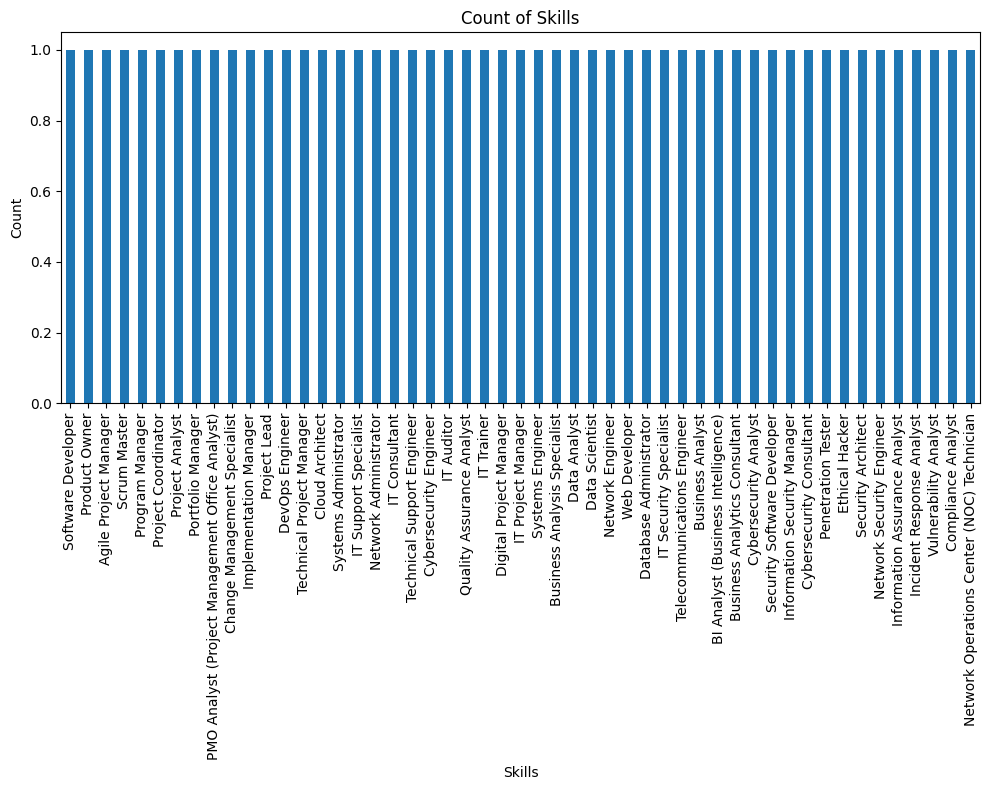

In [44]:
plot_skill_count(infocomm_jobs)

In [45]:
def clean_and_split(input_string):
    elements = input_string.split('\n')
    cleaned_elements = []
    for elem in elements:
        parts = elem.split('. ')
        if len(parts) >= 2 and parts[1].strip():
            cleaned_elements.append(parts[1].strip())
    return cleaned_elements

In [11]:
result_list = []
for x in all_data_df["competences"]:
    elements = x.split('\n')
    for elem in elements:
        parts = elem.split('. ')
        if len(parts) >= 2 and parts[1].strip():
            result_list.append(parts[1].strip())

In [20]:
from collections import Counter

Counter(result_list).keys() # equals to list(set(words))
Counter(result_list).values() # counts the elements' frequency

dict_values([1, 1, 1, 1, 1, 10, 6, 56, 132, 1, 42, 1, 390, 1, 18, 1, 1, 1, 1, 1, 1, 16, 14, 162, 582, 1, 1, 1, 1, 4, 5, 2, 1, 359, 7, 69, 12, 17, 7, 2, 28, 1, 1, 1, 2, 13, 30, 322, 11, 92, 119, 6, 5, 120, 4, 4, 65, 19, 254, 10, 19, 41, 17, 39, 14, 10, 4, 4, 72, 32, 37, 60, 5, 25, 13, 7, 42, 11, 11, 7, 2, 2, 27, 58, 15, 442, 416, 5, 10, 3, 24, 7, 84, 3, 3, 41, 65, 1, 8, 1, 76, 7, 1, 8, 1, 1, 4, 1, 1, 75, 71, 4, 328, 54, 16, 15, 178, 1, 1, 121, 274, 3, 11, 679, 6, 1, 1, 43, 15, 2, 30, 517, 364, 3, 52, 22, 1, 107, 29, 5, 82, 11, 24, 60, 3, 3, 1, 5, 1, 1, 110, 63, 415, 31, 6, 21, 33, 1, 1, 1, 1, 1, 11, 145, 22, 24, 32, 6, 83, 24, 116, 10, 5, 5, 3, 1, 11, 100, 1, 9, 1, 1, 1, 5, 1, 1, 1, 117, 1, 1, 8, 14, 1, 1, 105, 443, 56, 194, 3, 1, 8, 112, 150, 139, 5, 223, 43, 697, 46, 60, 1, 1, 29, 1, 4, 3, 3, 8, 7, 26, 2, 5, 2, 128, 29, 11, 21, 11, 3, 2, 2, 8, 18, 2, 10, 2, 7, 17, 64, 38, 21, 26, 5, 1, 2, 2, 16, 5, 1, 1, 6, 215, 13, 4, 3, 9, 3, 1, 5, 2, 1, 1, 36, 10, 86, 70, 7, 1, 1, 1, 1, 1, 1, 8, 23

In [12]:
unique_set = set(result_list)
unique_count = len(unique_set)

In [13]:
golden_temp = pd.read_csv("golden_temp.csv")
golden = pd.read_csv("golden_ksa.csv")
#------------------------------------
set_ksa_text_TEMP = set()
set_ksa_stext_TEMP = set()
for ksa in golden_temp["Text"]:
    set_ksa_text_TEMP.add(ksa)
for ksa in golden_temp["Standard text"]:
    set_ksa_text_TEMP.add(ksa)
#------------------------------------
set_ksa_text = set()
set_ksa_stext = set()
for ksa in golden["Text"]:
    set_ksa_text.add(ksa)
for ksa in golden["Standard text"]:
    set_ksa_text.add(ksa)

In [15]:
len(set_ksa_text_TEMP)

34171

In [16]:
total_annotated_text_TEMP = 0
total_annotated_stext_TEMP = 0
total_annotated_text = 0
total_annotated_stext = 0
for item in unique_set:
    if item in set_ksa_text_TEMP:
        total_annotated_text_TEMP += 1
for item in unique_set:
    if item in set_ksa_stext_TEMP:
        total_annotated_stext_TEMP += 1
for item in unique_set:
    if item in set_ksa_text:
        total_annotated_text += 1
for item in unique_set:
    if item in set_ksa_stext:
        total_annotated_stext += 1

In [17]:
print("TOTAL JOB POSTS: ", all_data_df.shape[0])
print("TOTAL RAW KSAs: ", len(result_list))
print("TOTAL UNIQUE KSAs: ", unique_count)
print("------------------------------------")
print("TOTAL UNIQUE 'TEXT' VALUES IN GOLDEN_TEMP: ", len(set_ksa_text_TEMP))
print("TOTAL UNIQUE 'STANDARD TEXT' VALUES IN GOLDEN_TEMP: ", len(set_ksa_stext_TEMP))
print("TEXT VALUES IN JOB POSTS: ", total_annotated_text_TEMP)
print("STANDARD TEXT VALUES IN JOB POSTS: ", total_annotated_stext_TEMP)
print("------------------------------------")
print("TOTAL UNIQUE 'TEXT' VALUES IN GOLDEN: ", len(set_ksa_text))
print("TOTAL UNIQUE 'STANDARD TEXT' VALUES IN GOLDEN: ", len(set_ksa_stext))
print("TEXT VALUES IN JOB POSTS: ", total_annotated_text)
print("STANDARD TEXT VALUES IN JOB POSTS: ", total_annotated_stext)

TOTAL JOB POSTS:  3072
TOTAL RAW KSAs:  98557
TOTAL UNIQUE KSAs:  42626
------------------------------------
TOTAL UNIQUE 'TEXT' VALUES IN GOLDEN_TEMP:  34171
TOTAL UNIQUE 'STANDARD TEXT' VALUES IN GOLDEN_TEMP:  0
TEXT VALUES IN JOB POSTS:  6383
STANDARD TEXT VALUES IN JOB POSTS:  0
------------------------------------
TOTAL UNIQUE 'TEXT' VALUES IN GOLDEN:  3379
TOTAL UNIQUE 'STANDARD TEXT' VALUES IN GOLDEN:  0
TEXT VALUES IN JOB POSTS:  1259
STANDARD TEXT VALUES IN JOB POSTS:  0


In [30]:
import pandas as pd

# Read golden KSA's
golden = pd.read_csv("golden_ksa.csv")
golden_temp = pd.read_csv("golden_temp.csv")

ksa_set = set()
k, s, a, o = 0, 0, 0, 0
set_k, set_s, set_a, set_o = set(), set(), set(), set()

for ksa in golden_temp["Standard text"]:
    ksa_set.add(ksa)
    indices = golden_temp.index[golden_temp["Standard text"] == ksa].tolist()
    if indices:
        index = indices[0]
        label = golden_temp.at[index, 'Label']
        if label == "Knowledge":
            k += 1
            set_k.add(ksa)
        elif label == "Skill":
            s += 1
            set_s.add(ksa)
        elif label == "Ability":
            a += 1
            set_a.add(ksa)
        elif label == "Other":
            o += 1
            set_o.add(ksa)
    else:
        print(f"No matching index found for '{ksa}'")

print(f"Total KSA's: {len(golden_temp)}")
print(f"Total UNIQUE KSA's: {len(ksa_set)}")
print("---------------------------------")
print(f"Total K: {k}")
print(f"Total S: {s}")
print(f"Total A: {a}")
print(f"Total O: {o}")
tot = k + s + a + o
print(f"Tot: {tot}")
print("---------------------------------")
print(f"Unique K: {len(set_k)}")
print(f"Unique S: {len(set_s)}")
print(f"Unique A: {len(set_a)}")
print(f"Unique O: {len(set_o)}")
tot_u = len(set_k) + len(set_s) + len(set_a) + len(set_o)
print(f"Tot: {tot_u}")

No matching index found for 'nan'
Total KSA's: 34192
Total UNIQUE KSA's: 32820
---------------------------------
Total K: 19443
Total S: 4487
Total A: 1735
Total O: 8524
Tot: 34189
---------------------------------
Unique K: 18806
Unique S: 3976
Unique A: 1513
Unique O: 8522
Tot: 32817
